# 2048 Algorithm Comparison Analysis

Comparing Expectimax (corner strategy) vs MCTS vs Random Agent performance, variability, and the difficulty cliff between tile tiers.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

## Load Data


In [26]:
# Load games summary data
expectimax_summary = pd.read_parquet('../data/processed/mass_expectimax_corner/games_summary.parquet')
mcts_summary = pd.read_parquet('../data/processed/mass_mcts_heuristic/games_summary.parquet')
random_summary = pd.read_parquet('../data/processed/random_games/games_summary.parquet')

# Add algorithm label
expectimax_summary['algorithm'] = 'Expectimax'
mcts_summary['algorithm'] = 'MCTS'
random_summary['algorithm'] = 'Random'

# Combine for easier comparison
all_games = pd.concat([expectimax_summary, mcts_summary, random_summary], ignore_index=True)

print(f"Expectimax games: {len(expectimax_summary)}")
print(f"MCTS games: {len(mcts_summary)}")
print(f"Random games: {len(random_summary)}")
print(f"\nExpectimax stats:")
print(expectimax_summary[['final_score', 'highest_tile', 'game_length']].describe())
print(f"\nMCTS stats:")
print(mcts_summary[['final_score', 'highest_tile', 'game_length']].describe())
print(f"\nRandom stats:")
print(random_summary[['final_score', 'highest_tile', 'game_length']].describe())


Expectimax games: 64
MCTS games: 64
Random games: 64

Expectimax stats:
        final_score  highest_tile  game_length
count     64.000000     64.000000    64.000000
mean   10174.500000    616.000000   643.875000
std     5871.212762    388.293458   292.094435
min     2188.000000    128.000000   207.000000
25%     5304.000000    256.000000   413.500000
50%     9296.000000    512.000000   598.000000
75%    12763.000000   1024.000000   769.000000
max    34540.000000   2048.000000  1783.000000

MCTS stats:
        final_score  highest_tile  game_length
count     64.000000     64.000000    64.000000
mean   16347.062500   1208.000000   908.078125
std     8527.466368    617.825372   399.414067
min     2080.000000    256.000000   172.000000
25%    11034.000000   1024.000000   637.500000
50%    14592.000000   1024.000000   854.000000
75%    23774.000000   2048.000000  1210.500000
max    32632.000000   2048.000000  1672.000000

Random stats:
       final_score  highest_tile  game_length
count   

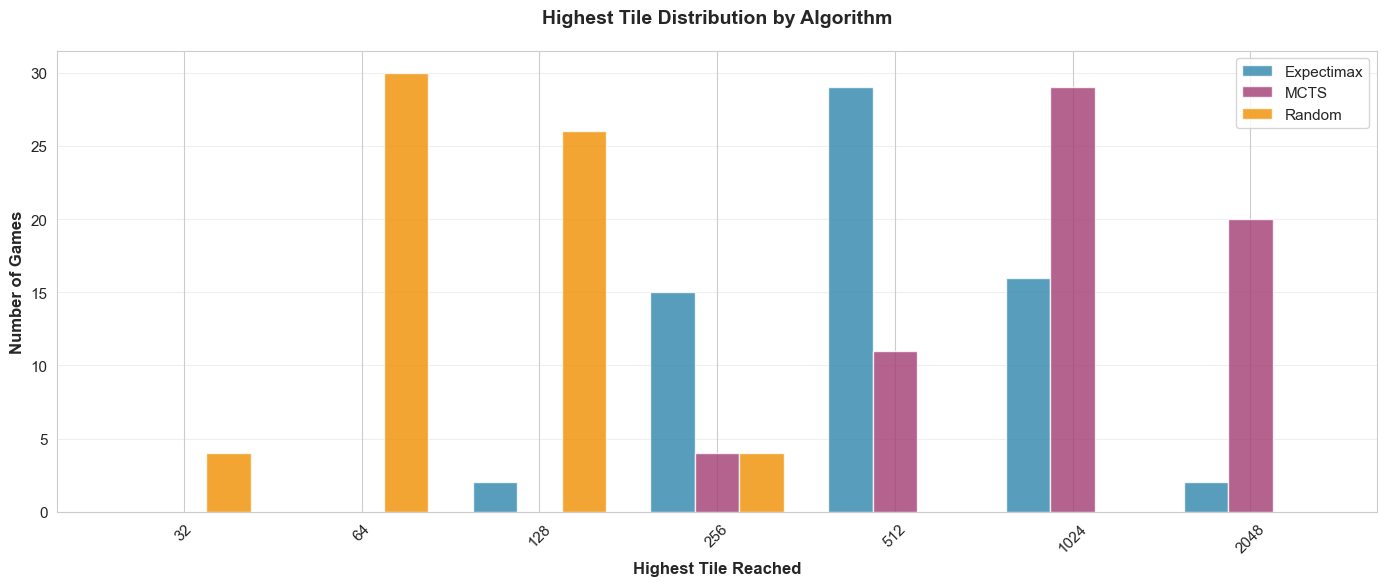


Highest Tile Reached - Game Counts:
 Tile  Expectimax  MCTS  Random
   32           0     0       4
   64           0     0      30
  128           2     0      26
  256          15     4       4
  512          29    11       0
 1024          16    29       0
 2048           2    20       0


In [ ]:
from scipy.interpolate import make_interp_spline

fig, ax = plt.subplots(figsize=(14, 6))

# Get tile values and counts for all algorithms
tile_values = sorted(all_games['highest_tile'].unique())
x_pos = np.arange(len(tile_values))
width = 0.25

expectimax_counts = [len(expectimax_summary[expectimax_summary['highest_tile'] == t]) for t in tile_values]
mcts_counts = [len(mcts_summary[mcts_summary['highest_tile'] == t]) for t in tile_values]
random_counts = [len(random_summary[random_summary['highest_tile'] == t]) for t in tile_values]

# Create bars
ax.bar(x_pos - width, expectimax_counts, width, label='Expectimax (count)', alpha=0.6, color='#2E86AB')
ax.bar(x_pos, mcts_counts, width, label='MCTS (count)', alpha=0.6, color='#A23B72')
ax.bar(x_pos + width, random_counts, width, label='Random (count)', alpha=0.6, color='#F18F01')

# Add smooth PDF curves
ax2 = ax.twinx()  # Create second y-axis for normalized density

# Function to create smooth curve
def create_smooth_curve(x_data, y_data, color, label):
    if len(x_data) > 3 and max(y_data) > 0:
        # Normalize to create PDF (area = 1)
        total = sum(y_data)
        y_normalized = [y / total for y in y_data]

        # Create smooth spline only if we have enough non-zero points
        non_zero_idx = [i for i, y in enumerate(y_normalized) if y > 0]
        if len(non_zero_idx) > 2:
            x_smooth = np.linspace(min(non_zero_idx), max(non_zero_idx), 200)
            spl = make_interp_spline([x_data[i] for i in non_zero_idx],
                                     [y_normalized[i] for i in non_zero_idx], k=2)
            y_smooth = spl(x_smooth)
            y_smooth = np.maximum(y_smooth, 0)  # Remove negative artifacts
            ax2.plot(x_smooth, y_smooth, color=color, linewidth=3, alpha=0.9,
                    label=label, linestyle='-')

create_smooth_curve(x_pos, expectimax_counts, '#2E86AB', 'Expectimax (PDF)')
create_smooth_curve(x_pos, mcts_counts, '#A23B72', 'MCTS (PDF)')
create_smooth_curve(x_pos, random_counts, '#F18F01', 'Random (PDF)')

# Formatting
ax.set_xlabel('Highest Tile Reached', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Games', fontsize=12, fontweight='bold')
ax2.set_ylabel('Probability Density', fontsize=12, fontweight='bold')
ax.set_title('Highest Tile Distribution by Algorithm (Bars = Counts, Lines = PDF)',
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels([str(int(t)) for t in tile_values], rotation=45)

# Combine legends
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, fontsize=9, loc='upper right')

ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print("\nHighest Tile Reached - Game Counts:")
comparison_df = pd.DataFrame({
    'Tile': tile_values,
    'Expectimax': expectimax_counts,
    'MCTS': mcts_counts,
    'Random': random_counts
})
print(comparison_df.to_string(index=False))


## 2. Win Rate Funnel

Visualizes the difficulty cliff - shows what % of games reach each tile tier.


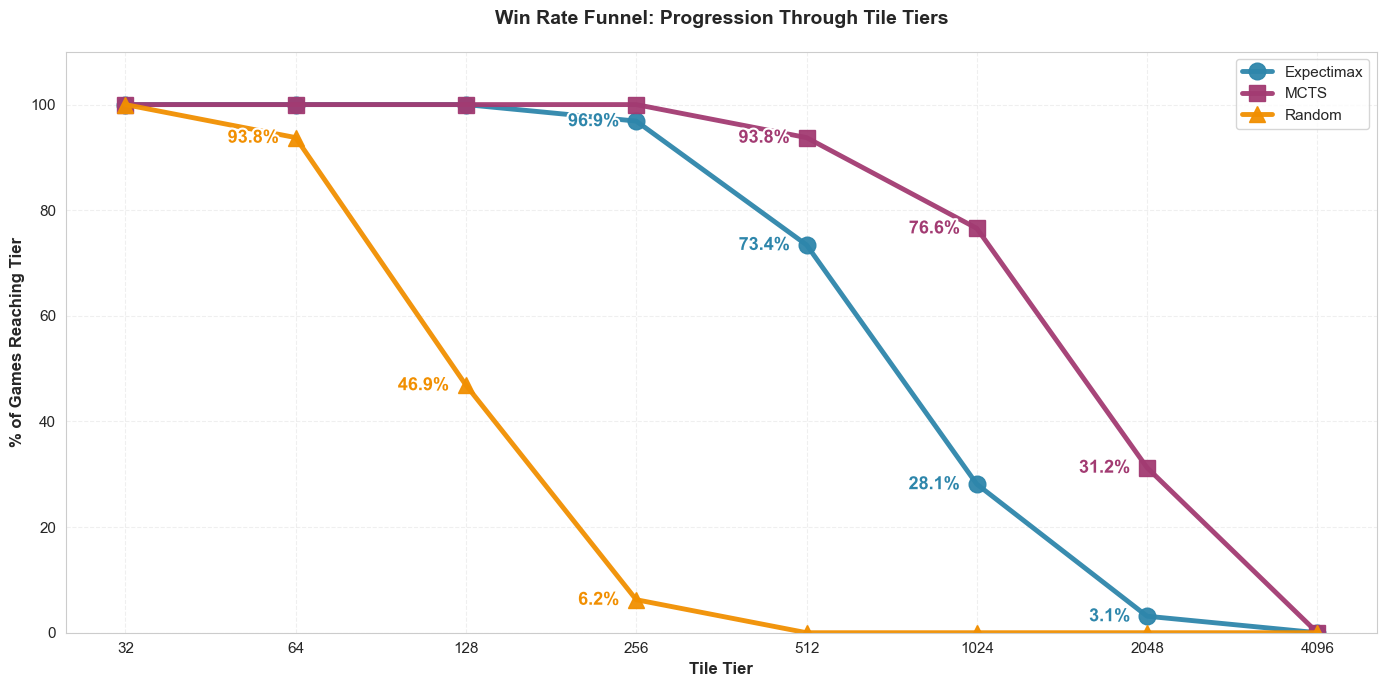


Win Rates (% reaching each tier):
 Tile Tier Expectimax   MCTS Random
        32     100.0% 100.0% 100.0%
        64     100.0% 100.0%  93.8%
       128     100.0% 100.0%  46.9%
       256      96.9% 100.0%   6.2%
       512      73.4%  93.8%   0.0%
      1024      28.1%  76.6%   0.0%
      2048       3.1%  31.2%   0.0%
      4096       0.0%   0.0%   0.0%


In [44]:
# Define tile tiers to track
tile_tiers = [32, 64, 128, 256, 512, 1024, 2048, 4096]

def calculate_reach_rates(df):
    """Calculate % of games that reached at least each tier."""
    total_games = len(df)
    rates = []
    for tier in tile_tiers:
        reached = len(df[df['highest_tile'] >= tier])
        rates.append((reached / total_games) * 100)
    return rates

expectimax_rates = calculate_reach_rates(expectimax_summary)
mcts_rates = calculate_reach_rates(mcts_summary)
random_rates = calculate_reach_rates(random_summary)

# Create funnel chart with line plot
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(tile_tiers))

# Plot lines with markers (larger markers)
ax.plot(x, expectimax_rates, marker='o', markersize=12, linewidth=3.5,
        label='Expectimax', color='#2E86AB', alpha=0.95)
ax.plot(x, mcts_rates, marker='s', markersize=12, linewidth=3.5,
        label='MCTS', color='#A23B72', alpha=0.95)
ax.plot(x, random_rates, marker='^', markersize=12, linewidth=3.5,
        label='Random', color='#F18F01', alpha=0.95)

# Add value labels with white outline for contrast (skip 0% and 100%)
from matplotlib import patheffects

for i, (exp, mcts, rand) in enumerate(zip(expectimax_rates, mcts_rates, random_rates)):
    if 0 < exp < 100:
        text = ax.text(i - 0.1, exp, f'{exp:.1f}%', ha='right', va='center',
                fontsize=13, fontweight='bold', color='#2E86AB')
        text.set_path_effects([patheffects.withStroke(linewidth=3, foreground='white')])
    if 0 < mcts < 100:
        text = ax.text(i - 0.1, mcts, f'{mcts:.1f}%', ha='right', va='center',
                fontsize=13, fontweight='bold', color='#A23B72')
        text.set_path_effects([patheffects.withStroke(linewidth=3, foreground='white')])
    if 0 < rand < 100:
        text = ax.text(i - 0.1, rand, f'{rand:.1f}%', ha='right', va='center',
                fontsize=13, fontweight='bold', color='#F18F01')
        text.set_path_effects([patheffects.withStroke(linewidth=3, foreground='white')])

# Formatting
ax.set_xlabel('Tile Tier', fontsize=12, fontweight='bold')
ax.set_ylabel('% of Games Reaching Tier', fontsize=12, fontweight='bold')
ax.set_title('Win Rate Funnel: Progression Through Tile Tiers', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels([str(t) for t in tile_tiers])
ax.set_ylim(0, 110)
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Print detailed table
print("\nWin Rates (% reaching each tier):")
funnel_df = pd.DataFrame({
    'Tile Tier': tile_tiers,
    'Expectimax': [f"{r:.1f}%" for r in expectimax_rates],
    'MCTS': [f"{r:.1f}%" for r in mcts_rates],
    'Random': [f"{r:.1f}%" for r in random_rates]
})
print(funnel_df.to_string(index=False))


## 3. Score Distribution Box Plots

Shows median performance and variability/reliability of each algorithm.


C:\Users\milleraa\AppData\Local\Temp\ipykernel_16340\1447527747.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=exp_mcts_data, x='algorithm', y='final_score', ax=ax1,
C:\Users\milleraa\AppData\Local\Temp\ipykernel_16340\1447527747.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=exp_mcts_data, x='algorithm', y='game_length', ax=ax3,


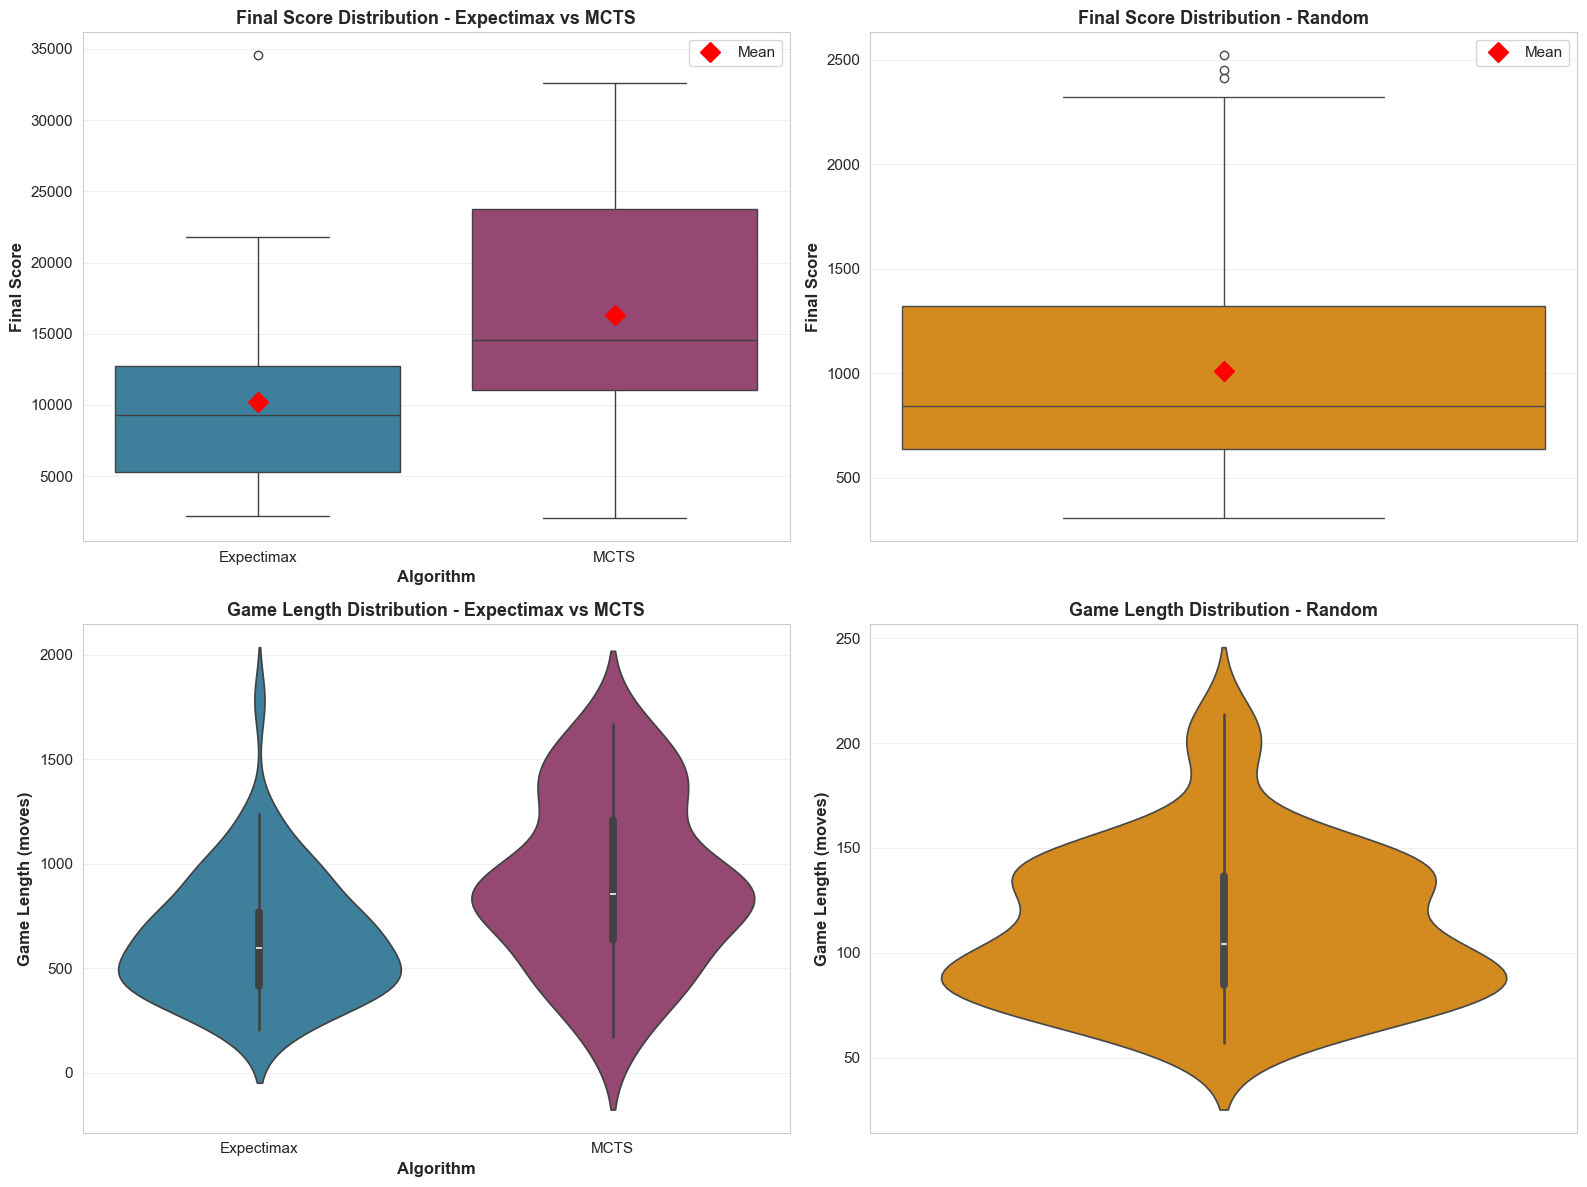


Score Statistics:
            count        mean          std     min      25%      50%      75%  \
algorithm                                                                       
Expectimax   64.0  10174.5000  5871.212762  2188.0   5304.0   9296.0  12763.0   
MCTS         64.0  16347.0625  8527.466368  2080.0  11034.0  14592.0  23774.0   
Random       64.0   1009.6250   513.034035   308.0    636.0    844.0   1322.0   

                max  
algorithm            
Expectimax  34540.0  
MCTS        32632.0  
Random       2520.0  

Game Length Statistics:
            count        mean         std    min    25%    50%     75%     max
algorithm                                                                     
Expectimax   64.0  643.875000  292.094435  207.0  413.5  598.0   769.0  1783.0
MCTS         64.0  908.078125  399.414067  172.0  637.5  854.0  1210.5  1672.0
Random       64.0  112.484375   36.454360   57.0   84.5  104.0   136.5   214.0

Coefficient of Variation (lower = more consi

In [34]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Top Left: Box plot for Expectimax and MCTS
exp_mcts_data = all_games[all_games['algorithm'].isin(['Expectimax', 'MCTS'])]
sns.boxplot(data=exp_mcts_data, x='algorithm', y='final_score', ax=ax1,
            palette=['#2E86AB', '#A23B72'], order=['Expectimax', 'MCTS'])
ax1.set_xlabel('Algorithm', fontsize=12, fontweight='bold')
ax1.set_ylabel('Final Score', fontsize=12, fontweight='bold')
ax1.set_title('Final Score Distribution - Expectimax vs MCTS', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
# Add mean markers
em_means = exp_mcts_data.groupby('algorithm')['final_score'].mean().reindex(['Expectimax', 'MCTS'])
ax1.plot([0, 1], em_means, 'D', color='red', markersize=10, label='Mean', zorder=3)
ax1.legend()

# Top Right: Box plot for Random only
random_data = all_games[all_games['algorithm'] == 'Random']
sns.boxplot(data=random_data, y='final_score', ax=ax2, color='#F18F01')
ax2.set_ylabel('Final Score', fontsize=12, fontweight='bold')
ax2.set_title('Final Score Distribution - Random', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
# Add mean marker
rand_mean = random_data['final_score'].mean()
ax2.plot(0, rand_mean, 'D', color='red', markersize=10, label='Mean', zorder=3)
ax2.legend()

# Bottom Left: Violin plot for Expectimax and MCTS
sns.violinplot(data=exp_mcts_data, x='algorithm', y='game_length', ax=ax3,
               palette=['#2E86AB', '#A23B72'], order=['Expectimax', 'MCTS'])
ax3.set_xlabel('Algorithm', fontsize=12, fontweight='bold')
ax3.set_ylabel('Game Length (moves)', fontsize=12, fontweight='bold')
ax3.set_title('Game Length Distribution - Expectimax vs MCTS', fontsize=13, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Bottom Right: Violin plot for Random only
sns.violinplot(data=random_data, y='game_length', ax=ax4, color='#F18F01')
ax4.set_ylabel('Game Length (moves)', fontsize=12, fontweight='bold')
ax4.set_title('Game Length Distribution - Random', fontsize=13, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("\nScore Statistics:")
print(all_games.groupby('algorithm')['final_score'].describe())

print("\nGame Length Statistics:")
print(all_games.groupby('algorithm')['game_length'].describe())

# Calculate coefficient of variation (measure of reliability)
print("\nCoefficient of Variation (lower = more consistent):")
for algo in ['Expectimax', 'MCTS', 'Random']:
    data = all_games[all_games['algorithm'] == algo]['final_score']
    cv = (data.std() / data.mean()) * 100
    print(f"{algo}: {cv:.2f}%")


## 4. Conditional Probability Matrix

Quantifies the "difficulty cliff" - probability of reaching the next tier given you reached the current tier.


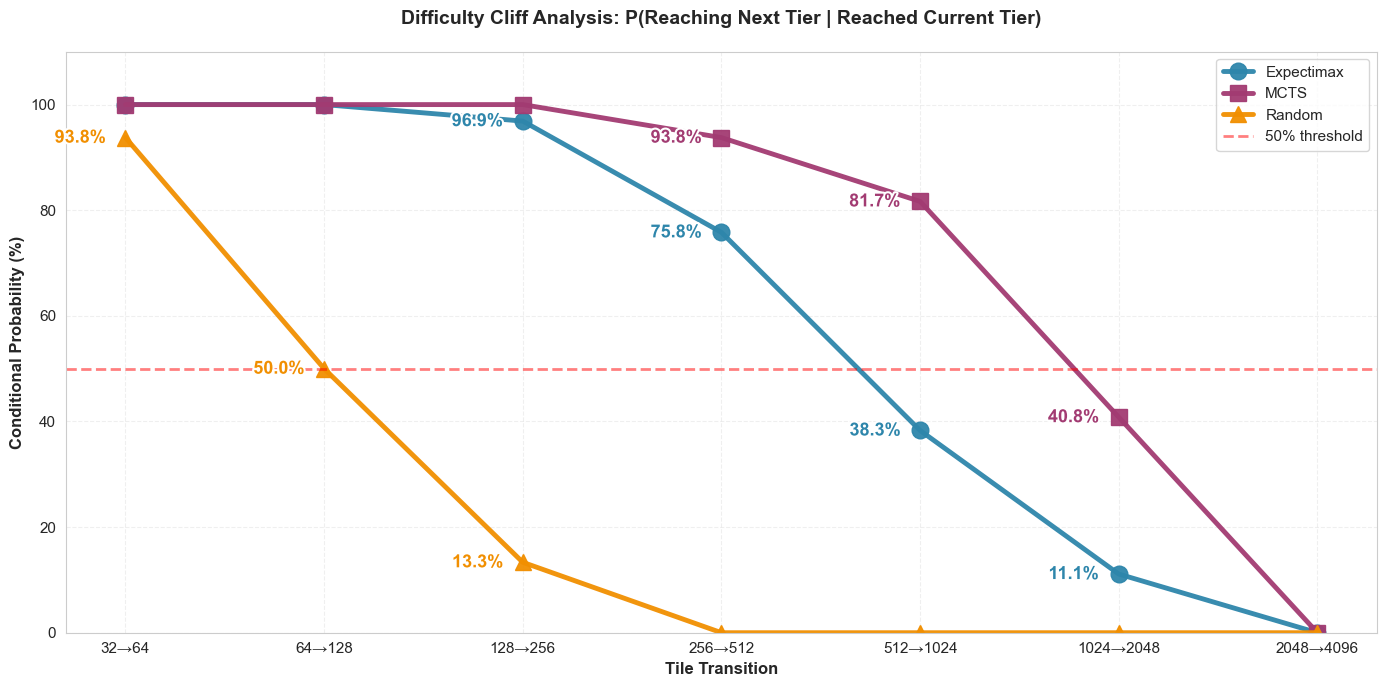


Conditional Probabilities (The Difficulty Cliff):
Transition Expectimax   MCTS Random
     32→64     100.0% 100.0%  93.8%
    64→128     100.0% 100.0%  50.0%
   128→256      96.9% 100.0%  13.3%
   256→512      75.8%  93.8%   0.0%
  512→1024      38.3%  81.7%   0.0%
 1024→2048      11.1%  40.8%   0.0%
 2048→4096       0.0%   0.0%   0.0%

Key Insight: Lower percentages indicate steeper difficulty cliffs.


In [46]:
def calculate_conditional_probabilities(df, tiers):
    """Calculate P(reaching tier[i+1] | reached tier[i])."""
    probs = []
    for i in range(len(tiers) - 1):
        current_tier = tiers[i]
        next_tier = tiers[i + 1]

        reached_current = df[df['highest_tile'] >= current_tier]
        if len(reached_current) == 0:
            probs.append(0)
        else:
            reached_next = len(reached_current[reached_current['highest_tile'] >= next_tier])
            prob = (reached_next / len(reached_current)) * 100
            probs.append(prob)
    return probs

tiers = [32, 64, 128, 256, 512, 1024, 2048, 4096]
transitions = [f"{tiers[i]}→{tiers[i+1]}" for i in range(len(tiers)-1)]

expectimax_cond_probs = calculate_conditional_probabilities(expectimax_summary, tiers)
mcts_cond_probs = calculate_conditional_probabilities(mcts_summary, tiers)
random_cond_probs = calculate_conditional_probabilities(random_summary, tiers)

# Create comparison plot with line plot
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(transitions))

# Plot lines with markers (larger markers)
ax.plot(x, expectimax_cond_probs, marker='o', markersize=12, linewidth=3.5,
        label='Expectimax', color='#2E86AB', alpha=0.95)
ax.plot(x, mcts_cond_probs, marker='s', markersize=12, linewidth=3.5,
        label='MCTS', color='#A23B72', alpha=0.95)
ax.plot(x, random_cond_probs, marker='^', markersize=12, linewidth=3.5,
        label='Random', color='#F18F01', alpha=0.95)

# Add reference line at 50%
ax.axhline(y=50, color='red', linestyle='--', alpha=0.5, linewidth=2, label='50% threshold')

# Add value labels with white outline for contrast (skip 0% and 100%)
from matplotlib import patheffects

for i, (exp, mcts, rand) in enumerate(zip(expectimax_cond_probs, mcts_cond_probs, random_cond_probs)):
    if 0 < exp < 100:
        text = ax.text(i - 0.1, exp, f'{exp:.1f}%', ha='right', va='center',
                fontsize=13, fontweight='bold', color='#2E86AB')
        text.set_path_effects([patheffects.withStroke(linewidth=3, foreground='white')])
    if 0 < mcts < 100:
        text = ax.text(i - 0.1, mcts, f'{mcts:.1f}%', ha='right', va='center',
                fontsize=13, fontweight='bold', color='#A23B72')
        text.set_path_effects([patheffects.withStroke(linewidth=3, foreground='white')])
    if 0 < rand < 100:
        text = ax.text(i - 0.1, rand, f'{rand:.1f}%', ha='right', va='center',
                fontsize=13, fontweight='bold', color='#F18F01')
        text.set_path_effects([patheffects.withStroke(linewidth=3, foreground='white')])

# Formatting
ax.set_xlabel('Tile Transition', fontsize=12, fontweight='bold')
ax.set_ylabel('Conditional Probability (%)', fontsize=12, fontweight='bold')
ax.set_title('Difficulty Cliff Analysis: P(Reaching Next Tier | Reached Current Tier)',
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(transitions, rotation=0)
ax.set_ylim(0, 110)
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Print table
print("\nConditional Probabilities (The Difficulty Cliff):")
cliff_df = pd.DataFrame({
    'Transition': transitions,
    'Expectimax': [f"{p:.1f}%" for p in expectimax_cond_probs],
    'MCTS': [f"{p:.1f}%" for p in mcts_cond_probs],
    'Random': [f"{p:.1f}%" for p in random_cond_probs]
})
print(cliff_df.to_string(index=False))

print("\nKey Insight: Lower percentages indicate steeper difficulty cliffs.")


## 5. Score Progression Over Time

Shows how games evolve differently for each algorithm with confidence bands.


In [32]:
# Load steps data
expectimax_steps = pd.read_parquet('../data/processed/mass_expectimax_corner/steps.parquet')
mcts_steps = pd.read_parquet('../data/processed/mass_mcts_heuristic/steps.parquet')
random_steps = pd.read_parquet('../data/processed/random_games/steps.parquet')

# Add algorithm labels
expectimax_steps['algorithm'] = 'Expectimax'
mcts_steps['algorithm'] = 'MCTS'
random_steps['algorithm'] = 'Random'

print(f"Expectimax steps: {len(expectimax_steps)}")
print(f"MCTS steps: {len(mcts_steps)}")
print(f"Random steps: {len(random_steps)}")


Expectimax steps: 41272
MCTS steps: 58181
Random steps: 7263



Median scores when first reaching each tile:
  Expectimax - 512: N/A, 1024: N/A, 2048: N/A
  MCTS - 512: N/A, 1024: N/A, 2048: N/A


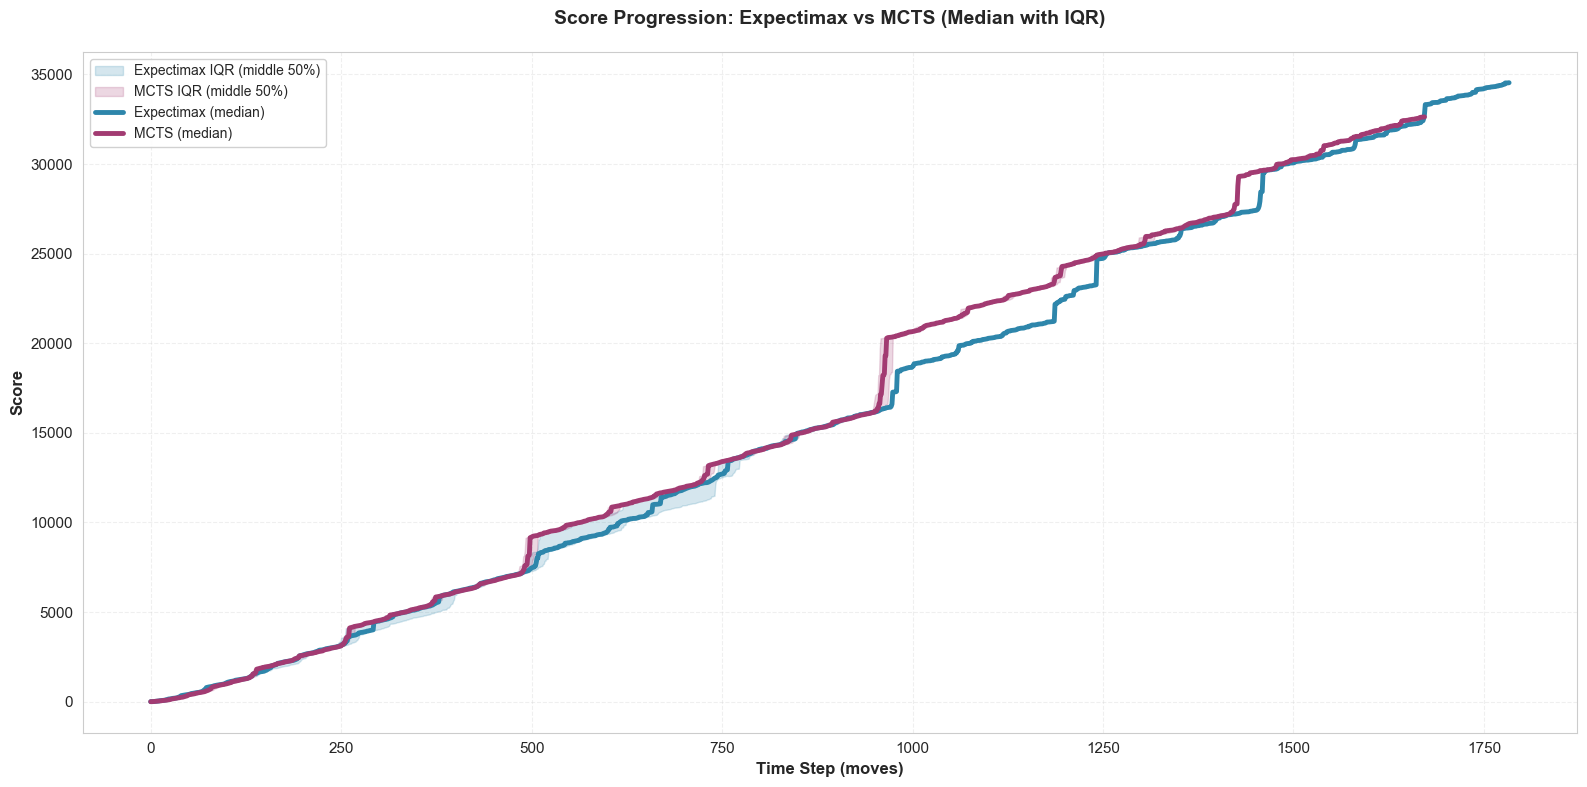


Score Progression at Key Timesteps:
 Timestep Expectimax  Exp Games  MCTS  MCTS Games
       50        410         64   365          64
      100       1045         64  1007          64
      200       2507         64  2560          61
      300       4324         59  4538          60
      400       5957         51  6088          60
      500       7838         41  8579          51
      600       9879         32 10552          48
      800      13957         15 14025          42
     1000      19449          5 20442          20
     1200      22456          2 24112          16
     1400      26984          1 27131          12
     1600      31464          1 31740           4


In [52]:
# Calculate statistics by timestep for each algorithm
def calculate_progression_stats(steps_df, max_t=None):
    """Calculate mean and confidence intervals for score over time."""
    if max_t is None:
        max_t = steps_df['t'].max()

    grouped = steps_df[steps_df['t'] <= max_t].groupby('t')['score']

    stats = pd.DataFrame({
        'mean': grouped.mean(),
        'std': grouped.std(),
        'count': grouped.count(),
        'median': grouped.median(),
        'q25': grouped.quantile(0.25),
        'q75': grouped.quantile(0.75)
    }).reset_index()

    # Calculate standard error and 95% CI
    stats['se'] = stats['std'] / np.sqrt(stats['count'])
    stats['ci_lower'] = stats['mean'] - 1.96 * stats['se']
    stats['ci_upper'] = stats['mean'] + 1.96 * stats['se']

    return stats

# Use full game length for both algorithms (no truncation)
max_t_expectimax = expectimax_steps['t'].max()
max_t_mcts = mcts_steps['t'].max()

expectimax_prog = calculate_progression_stats(expectimax_steps, max_t=max_t_expectimax)
mcts_prog = calculate_progression_stats(mcts_steps, max_t=max_t_mcts)

# Create the plot
fig, ax = plt.subplots(figsize=(16, 8))

# Only show variation bands where we have reasonable sample sizes (>10 games)
exp_sufficient = expectimax_prog[expectimax_prog['count'] >= 10]
mcts_sufficient = mcts_prog[mcts_prog['count'] >= 10]

# Plot variation bands (IQR: 25th to 75th percentile) first (so lines are on top)
ax.fill_between(exp_sufficient['t'],
                exp_sufficient['q25'],
                exp_sufficient['q75'],
                alpha=0.2, color='#2E86AB', label='Expectimax IQR (middle 50%)')
ax.fill_between(mcts_sufficient['t'],
                mcts_sufficient['q25'],
                mcts_sufficient['q75'],
                alpha=0.2, color='#A23B72', label='MCTS IQR (middle 50%)')

# Calculate actual median scores when key tiles are first reached
def get_tile_achievement_scores(steps_df, summary_df):
    """Get the score when each tile is first achieved in each game."""
    tile_scores = {512: [], 1024: [], 2048: []}

    for game_id in summary_df['game_id'].unique():
        game_steps = steps_df[steps_df['game_id'] == game_id].sort_values('t')
        highest_tile = summary_df[summary_df['game_id'] == game_id]['highest_tile'].values[0]

        # Track which tiles we've seen
        seen_tiles = set()

        for _, step in game_steps.iterrows():
            # Check tile counts to see which tiles exist
            tile_counts = step.get('tile_counts', {})

            for tile in [512, 1024, 2048]:
                if tile <= highest_tile and tile not in seen_tiles:
                    # Check if this tile exists in this step
                    if str(tile) in tile_counts and tile_counts[str(tile)] > 0:
                        tile_scores[tile].append(step['score'])
                        seen_tiles.add(tile)

    return {tile: np.median(scores) if scores else None for tile, scores in tile_scores.items()}

# Get median scores for both algorithms
exp_tile_scores = get_tile_achievement_scores(expectimax_steps, expectimax_summary)
mcts_tile_scores = get_tile_achievement_scores(mcts_steps, mcts_summary)

# Combine - use the lower median (more conservative threshold)
tile_thresholds = {}
for tile in [512, 1024, 2048]:
    scores = [s for s in [exp_tile_scores.get(tile), mcts_tile_scores.get(tile)] if s is not None]
    if scores:
        tile_thresholds[tile] = min(scores)  # Use minimum as the threshold

# Plot median lines (thicker, on top)
ax.plot(expectimax_prog['t'], expectimax_prog['median'],
        label='Expectimax (median)', color='#2E86AB', linewidth=3.5, zorder=3)
ax.plot(mcts_prog['t'], mcts_prog['median'],
        label='MCTS (median)', color='#A23B72', linewidth=3.5, zorder=3)

# Add horizontal lines for key tile achievement thresholds
for tile, score in sorted(tile_thresholds.items()):
    ax.axhline(y=score, color='gray', linestyle='--', linewidth=1.5, alpha=0.5, zorder=1)
    ax.text(ax.get_xlim()[1] * 0.98, score + 400, f'{tile} tile (~{score:,.0f})',
            ha='right', va='bottom', fontsize=9, color='gray',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='white', edgecolor='gray', alpha=0.8))

print("\nMedian scores when first reaching each tile:")
exp_512 = f"{exp_tile_scores.get(512):.0f}" if exp_tile_scores.get(512) is not None else "N/A"
exp_1024 = f"{exp_tile_scores.get(1024):.0f}" if exp_tile_scores.get(1024) is not None else "N/A"
exp_2048 = f"{exp_tile_scores.get(2048):.0f}" if exp_tile_scores.get(2048) is not None else "N/A"
mcts_512 = f"{mcts_tile_scores.get(512):.0f}" if mcts_tile_scores.get(512) is not None else "N/A"
mcts_1024 = f"{mcts_tile_scores.get(1024):.0f}" if mcts_tile_scores.get(1024) is not None else "N/A"
mcts_2048 = f"{mcts_tile_scores.get(2048):.0f}" if mcts_tile_scores.get(2048) is not None else "N/A"

print(f"  Expectimax - 512: {exp_512}, 1024: {exp_1024}, 2048: {exp_2048}")
print(f"  MCTS - 512: {mcts_512}, 1024: {mcts_1024}, 2048: {mcts_2048}")

# Formatting
ax.set_xlabel('Time Step (moves)', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Score Progression: Expectimax vs MCTS (Median with IQR)',
             fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=10, loc='upper left', framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Print summary at key timesteps
print("\nScore Progression at Key Timesteps:")
key_timesteps = [50, 100, 200, 300, 400, 500, 600, 800, 1000, 1200, 1400, 1600]
comparison_data = []

for t in key_timesteps:
    exp_row = expectimax_prog[expectimax_prog['t'] == t]
    mcts_row = mcts_prog[mcts_prog['t'] == t]

    if not exp_row.empty or not mcts_row.empty:
        row_data = {'Timestep': t}

        if not exp_row.empty:
            row_data['Expectimax'] = f"{exp_row['mean'].values[0]:.0f}"
            row_data['Exp Games'] = int(exp_row['count'].values[0])
        else:
            row_data['Expectimax'] = "-"
            row_data['Exp Games'] = 0

        if not mcts_row.empty:
            row_data['MCTS'] = f"{mcts_row['mean'].values[0]:.0f}"
            row_data['MCTS Games'] = int(mcts_row['count'].values[0])
        else:
            row_data['MCTS'] = "-"
            row_data['MCTS Games'] = 0

        comparison_data.append(row_data)

if comparison_data:
    prog_df = pd.DataFrame(comparison_data)
    print(prog_df.to_string(index=False))


## Summary Statistics


In [53]:
print("="*60)
print("OVERALL COMPARISON SUMMARY")
print("="*60)

for algo in ['Expectimax', 'MCTS', 'Random']:
    df = all_games[all_games['algorithm'] == algo]
    print(f"\n{algo}:")
    print(f"  Games played: {len(df)}")
    print(f"  Mean score: {df['final_score'].mean():.0f} (±{df['final_score'].std():.0f})")
    print(f"  Median score: {df['final_score'].median():.0f}")
    print(f"  Mean game length: {df['game_length'].mean():.1f} moves")
    print(f"  Highest tile (max): {df['highest_tile'].max():.0f}")
    print(f"  Highest tile (median): {df['highest_tile'].median():.0f}")
    print(f"  2048 win rate: {(df['reached_2048'].sum() / len(df) * 100):.1f}%")
    print(f"  4096 win rate: {(df['reached_4096'].sum() / len(df) * 100):.1f}%")

print("\n" + "="*60)


OVERALL COMPARISON SUMMARY

Expectimax:
  Games played: 64
  Mean score: 10174 (±5871)
  Median score: 9296
  Mean game length: 643.9 moves
  Highest tile (max): 2048
  Highest tile (median): 512
  2048 win rate: 3.1%
  4096 win rate: 0.0%

MCTS:
  Games played: 64
  Mean score: 16347 (±8527)
  Median score: 14592
  Mean game length: 908.1 moves
  Highest tile (max): 2048
  Highest tile (median): 1024
  2048 win rate: 31.2%
  4096 win rate: 0.0%

Random:
  Games played: 64
  Mean score: 1010 (±513)
  Median score: 844
  Mean game length: 112.5 moves
  Highest tile (max): 256
  Highest tile (median): 64
  2048 win rate: 0.0%
  4096 win rate: 0.0%

